In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# load mnist
train_ds = MNIST('data', train=True, download=True, transform=ToTensor())
test_ds = MNIST('data', train=False, download=True , transform=ToTensor())

# create data loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=12)
val_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=12)

sample = next(iter(train_loader))

In [29]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, latent_dim, 1, padding=0)
        )

    def forward(self, x):
        return self.encoder(x)


In [46]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, padding=1)
        )

    def forward(self, x):
        return self.decoder(x)

In [56]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta

        w_init = torch.nn.init.uniform_
        self.embeddings = nn.Parameter(w_init(torch.empty(self.embedding_dim, self.num_embeddings)))
        
    def forward(self, x):
        input_shape = x.shape
        flattened = x.view(-1, self.embedding_dim)

        encoding_indices = self.get_code_indices(flattened)
        encodings = F.one_hot(encoding_indices, num_classes=self.num_embeddings).to(flattened.device)
        quantized = torch.matmul(encodings.float(), self.embeddings.t())

        quantized = quantized.view(input_shape)

        commitment_loss = torch.mean((quantized.detach() - x) ** 2)
        codebook_loss = torch.mean((quantized - x.detach()) ** 2)
        self.loss = self.beta * commitment_loss + codebook_loss

        quantized = x + (quantized - x).detach()
        return quantized, self.loss, encodings

    def get_code_indices(self, flattened_inputs):
        similarity = torch.matmul(flattened_inputs, self.embeddings)
        distances = (torch.sum(flattened_inputs ** 2, dim=1, keepdim=True)
                     + torch.sum(self.embeddings ** 2, dim=0)
                     - 2 * similarity)

        encoding_indices = torch.argmin(distances, dim=1)
        return encoding_indices

In [57]:
class VQVAE(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25):
        super(VQVAE, self).__init__()
        self.encoder = Encoder()
        self.vq = VectorQuantizer(num_embeddings, embedding_dim, beta)
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        z_q, loss, _ = self.vq(z)
        x_hat = self.decoder(z_q)

        loss = loss + F.mse_loss(x_hat, x)
        
        return x_hat, loss

model = VQVAE(64, 16)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(model, train_loader, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        for i, (x, _) in enumerate(train_loader):
            optimizer.zero_grad()
            x_hat, loss = model(x)
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f'Epoch {epoch}, iter {i}, loss {loss.item():.4f}')


In [58]:
train(model, train_loader, optimizer, num_epochs=5)

Epoch 0, iter 0, loss 0.2947
Epoch 0, iter 100, loss 0.1506
Epoch 0, iter 200, loss 0.1363
Epoch 0, iter 300, loss 0.1180
Epoch 0, iter 400, loss 0.1119
Epoch 0, iter 500, loss 0.0963
Epoch 0, iter 600, loss 0.0866
Epoch 0, iter 700, loss 0.0954
Epoch 0, iter 800, loss 0.0956
Epoch 0, iter 900, loss 0.0895
Epoch 0, iter 1000, loss 0.0799
Epoch 0, iter 1100, loss 0.0897
Epoch 0, iter 1200, loss 0.0752
Epoch 0, iter 1300, loss 0.0777
Epoch 0, iter 1400, loss 0.0783
Epoch 0, iter 1500, loss 0.0814
Epoch 0, iter 1600, loss 0.0763
Epoch 0, iter 1700, loss 0.0763
Epoch 0, iter 1800, loss 0.0830
Epoch 1, iter 0, loss 0.0715
Epoch 1, iter 100, loss 0.0735
Epoch 1, iter 200, loss 0.0657
Epoch 1, iter 300, loss 0.0653
Epoch 1, iter 400, loss 0.0646
Epoch 1, iter 500, loss 0.0750
Epoch 1, iter 600, loss 0.0724
Epoch 1, iter 700, loss 0.0660
Epoch 1, iter 800, loss 0.0637
Epoch 1, iter 900, loss 0.0658
Epoch 1, iter 1000, loss 0.0654
Epoch 1, iter 1100, loss 0.0623
Epoch 1, iter 1200, loss 0.0567


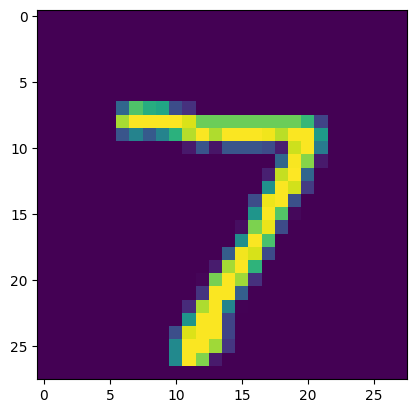

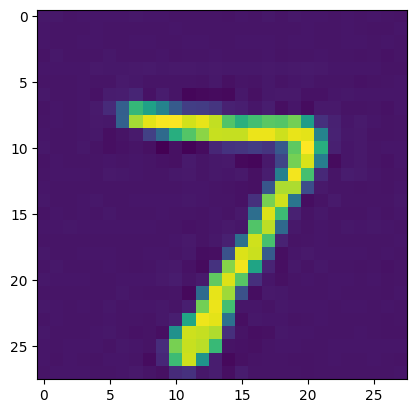

In [59]:
#save model to file
torch.save(model.state_dict(), 'vq_vae.pth')

#print reconsturction and original image
x, _ = next(iter(val_loader))

x_hat, _ = model(x)

import matplotlib.pyplot as plt
plt.imshow(x[0, 0])
plt.show()
plt.imshow(x_hat[0, 0].detach())
plt.show()
